# Data Preparation

In [9]:
import os 
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import plotly.express as px
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer
from sklearn.preprocessing import StandardScaler
from ipynb.fs.full.Utils import loadDataFrames

In [10]:
def deleteOutliersByField(df, field):
    iqr = 1.5 * (np.percentile(df[field], 75)) - (np.percentile(df[field], 25))
    greaterThan75 = df[df[field] > (iqr + np.percentile(df[field], 75))]
    print('amount of rows to delete greater than 75' , len(greaterThan75))
    lesserThan25 = df[df[field] < (np.percentile(df[field], 25) - iqr )]
    print('amount of rows to delete lesser than 25' , len(lesserThan25))
    df.drop(greaterThan75.index, inplace = True)
    df.drop(lesserThan25.index, inplace = True)
    
def printNewShapeDF(df):
    print('::: New Shape Dataframe', df.shape)
    
def getRenameObject(enc, columnNames):
    encodedFeaturesNames = enc.get_feature_names_out(columnNames)
    columns = {}
    for i in range(0,len(encodedFeaturesNames)):
        columns[i] = encodedFeaturesNames[i]
    return columns, encodedFeaturesNames


## -0.000999, 0.000186]    1
## (0.000186, 0.985]       2
##  0 = 0

def getInstrumentalnessCat(row):
    inst = row.instrumentalness
    if inst == 0:
        val = 0
    elif inst >= -0.000999 and inst < 0.000186:
        val = 1
    else:
        val = 2
    return val

In [83]:
spotifyFeatures, transitionMatrices, df = loadDataFrames()

In [84]:
df.mode

<bound method DataFrame.mode of                id_spotify_track  \
id                                
23       2ap1hCe7wyOWkMJsnIn0V1   
105      0KlWpxzYGq2sjVmwPHprxM   
118      75a66iUfwKdJb5n9juvXRI   
120      3QPQItOROGQUBbStogfu2g   
292      4w2Yq2cklbssmUtUy5Vh6H   
...                         ...   
5000017  34dnNAUoIPcwnK0RtVMBWZ   
5000018  49Nzxf1LskunwmZ6EyWUew   
5000019  49ilSrZNQcle6PYw8rtvzM   
5000020  66Z3LdLjtwfIdHFF0wZa5B   
5000023  6f46TyGZm5oeKIP54PLvql   

                                                  id_track  danceability  \
id                                                                         
23                                                       1         0.494   
105                                                     11         0.582   
118                                                     14         0.614   
120                                                     18         0.319   
292                                                     

In [12]:
columnName = 'speechiness'
numOfUniqueValues = len(df[columnName].value_counts())
print( 'fraction of unique values over the sample size', numOfUniqueValues / len(df) )
print( 'The ratio of the frequency of the most prevalent value to the frequency of the second most prevalent value is large', numOfUniqueValues / len(df) )

fraction of unique values over the sample size 0.19839679358717435
The ratio of the frequency of the most prevalent value to the frequency of the second most prevalent value is large 0.19839679358717435


## Rule of thumb from book applied predictive modeling related to variance

- The fraction of unique values over the sample size is low (say 10 %).
- The ratio of the frequency of the most prevalent value to the frequency of the second most prevalent value is large (say around 20).


If both of these criteria are true and the model in question is susceptible to this type of predictor, it may be advantageous to remove the variable from the model.


## Cleaning Data

In [13]:
spotifyFeatures

,id_spotify_track,id_track,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,...,valence,tempo,duration_ms,time_signature,name,popularity,album_name,release_date,year,mood
id,,,,,,,,,,,,,,,,,,,,,
23,2ap1hCe7wyOWkMJsnIn0V1,1,0.494,0.756,7,-8.504,1,0.0432,0.001400,0.005200,...,0.589,133.337,205547.0,4.0,beer drinkers and hell raisers,51.0,Tres Hombres (Expanded 2006 Remaster),1973-07-26,1973.0,7.0
105,0KlWpxzYGq2sjVmwPHprxM,11,0.582,0.744,7,-9.155,1,0.0336,0.000458,0.001320,...,0.674,133.344,272533.0,4.0,ball and chain,26.0,English Settlement,1982-02-12,1982.0,10.0
118,75a66iUfwKdJb5n9juvXRI,14,0.614,0.755,2,-5.829,1,0.0276,0.016200,0.000002,...,0.645,92.622,144787.0,4.0,los angeles,45.0,Los Angeles,1980-04-26,1980.0,7.0
120,3QPQItOROGQUBbStogfu2g,18,0.319,0.807,11,-6.504,0,0.0388,0.001040,0.290000,...,0.601,118.097,226680.0,4.0,the hungry wolf,10.0,Under The Big Black Sun,1982,1982.0,7.0
234,0L2vsEl6rki4Pz0OsoIrNb,20,0.673,0.706,3,-10.107,1,0.0283,0.444000,0.003360,...,0.953,93.157,275067.0,4.0,roses are free,24.0,Chocolate & Cheese,1994-09-27,1994.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5000013,2LbHYfTYW6TipHInIjqdaQ,The Scientist - Coldplay (Boyce Avenue feat. H...,0.334,0.252,8,-11.776,1,0.0287,0.722000,0.000000,...,0.214,153.879,251514.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN
5000018,49Nzxf1LskunwmZ6EyWUew,The Scientist - Coldplay _ Alex Goot & Jada Fa...,0.525,0.292,9,-8.809,1,0.0260,0.910000,0.000000,...,0.133,75.009,248227.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN
5000019,49ilSrZNQcle6PYw8rtvzM,The Scientist - The Petersens (LIVE) (128kbit_...,0.549,0.283,9,-11.006,1,0.0284,0.661000,0.000008,...,0.163,76.992,303426.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
print('spotifyFeatures len :', len(spotifyFeatures))
print('transitionMatrices len :', len(transitionMatrices))

spotifyFeatures len : 3495
transitionMatrices len : 3511


In [15]:
df[df.duplicated(subset=['id_track'])]

,id_spotify_track,id_track,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,...,1276,1278,1281,1286,1287,1288,1290,1292,1294,1295
id,,,,,,,,,,,,,,,,,,,,,


In [16]:
len(df.columns.tolist())

684

In [17]:
s = df.nunique(axis=0)
s[s < 15].index

Index(['key', 'mode', 'time_signature', 'mood', '2', '4', '8', '9', '13', '16',
       ...
       '1267', '1271', '1275', '1276', '1278', '1286', '1288', '1290', '1294',
       '1295'],
      dtype='object', length=435)

In [18]:
spotifyFeatures.columns

Index(['id_spotify_track', 'id_track', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature', 'name',
       'popularity', 'album_name', 'release_date', 'year', 'mood'],
      dtype='object')

## Removing useless columns

In [19]:
df = df.drop(['id_spotify_track', 'id_track', 'popularity', 'duration_ms', 'release_date', 'name', 'album_name'], axis=1)

In [20]:
df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,1276,1278,1281,1286,1287,1288,1290,1292,1294,1295
id,,,,,,,,,,,,,,,,,,,,,
23,0.494,0.756,7,-8.504,1,0.0432,0.001400,0.005200,0.1640,0.589,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
105,0.582,0.744,7,-9.155,1,0.0336,0.000458,0.001320,0.0405,0.674,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
118,0.614,0.755,2,-5.829,1,0.0276,0.016200,0.000002,0.0831,0.645,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
120,0.319,0.807,11,-6.504,0,0.0388,0.001040,0.290000,0.1310,0.601,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
292,0.496,0.527,6,-7.234,1,0.0339,0.195000,0.000000,0.1380,0.283,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Checking Skewness [here](https://www.spcforexcel.com/knowledge/basic-statistics/are-skewness-and-kurtosis-useful-statistics#:~:text=If%20the%20skewness%20is%20between,the%20data%20are%20highly%20skewed)

<font color="blue"> 
Analyzing the skewness of the continous variables it is found that:
</font>

    
Fairly Simetrical (-0.5, 0.5):
- danceability
- energy
- valence
- tempo
    
Moderately skewed (-1, 0.5) or (0.5, 1)
- acousticness

Highely skewed less than -1 or greater than 1
- instrumentalness
- liveness
- speechiness
- loudness

In [23]:
continousVariables = ['loudness', 'danceability','energy', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

In [24]:
df[continousVariables].skew(axis = 0, skipna = True)

loudness           -1.248593
danceability       -0.081727
energy             -0.154516
speechiness         5.709233
acousticness        0.524834
instrumentalness    5.566510
liveness            2.580310
valence             0.437050
tempo               0.298171
dtype: float64

### Check columns with low variance

In [25]:
spotifyFeatures.var()

danceability        2.105984e-02
energy              5.130312e-02
key                 1.240360e+01
loudness            1.446477e+01
mode                1.737347e-01
speechiness         2.029607e-03
acousticness        1.027884e-01
instrumentalness    1.720458e-02
liveness            2.752163e-02
valence             5.227496e-02
tempo               8.606195e+02
duration_ms         4.995677e+09
time_signature      1.178481e-01
popularity          3.431477e+02
year                2.408412e+02
mood                8.798950e+00
dtype: float64

# (?) Check whether its better to apply outliers techniques, although this logic is being infered from descriptions and data

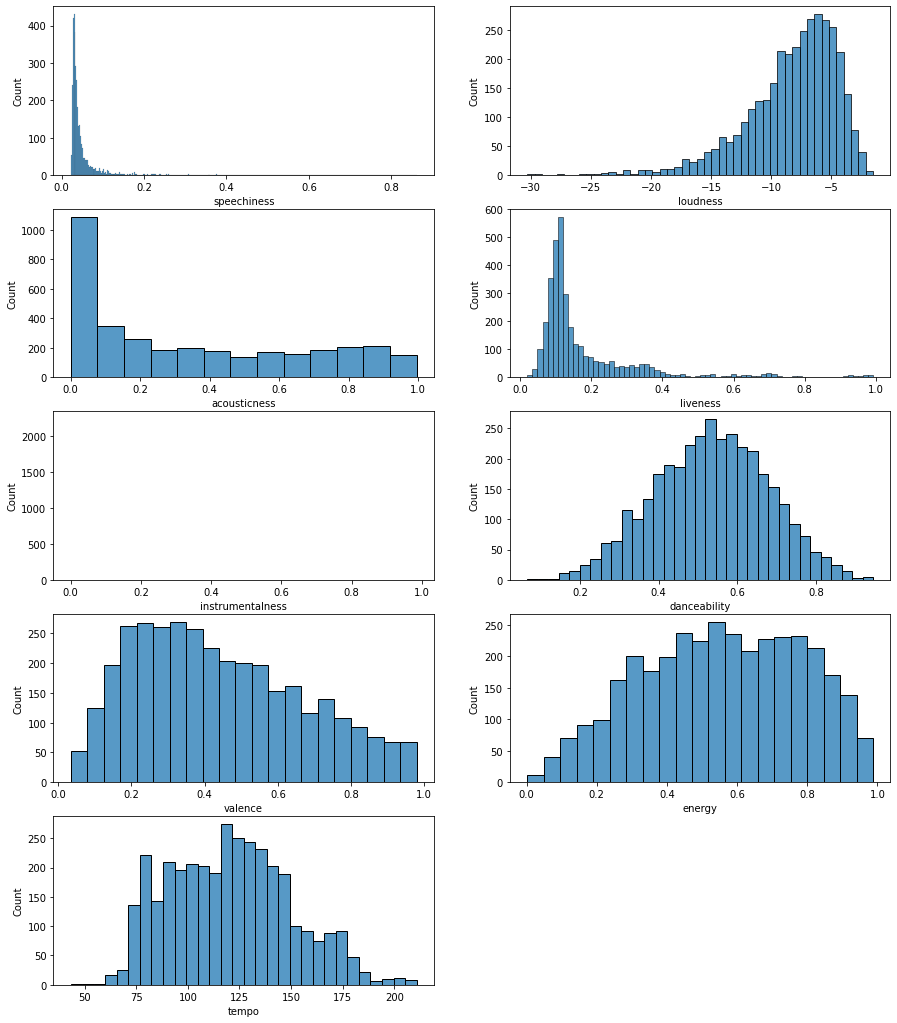

In [26]:
plt.figure(figsize=(15,18))

numRows = 5
numColumns = 2

plt.subplot(numRows, numColumns, 1); 
sns.histplot(df['speechiness'])

plt.subplot(numRows,numColumns,2)
sns.histplot(df['loudness'])

plt.subplot(numRows, numColumns, 3);
sns.histplot(df['acousticness'])

plt.subplot(numRows, numColumns, 4);
sns.histplot(df['liveness'])

plt.subplot(numRows, numColumns, 5);
sns.histplot(df['instrumentalness'])

plt.subplot(numRows, numColumns, 6); 
sns.histplot(df['danceability'])

plt.subplot(numRows, numColumns, 7); 
sns.histplot(df['valence'])

plt.subplot(numRows, numColumns, 8); 
sns.histplot(df['energy'])

plt.subplot(numRows, numColumns, 9); 
sns.histplot(df['tempo'])


plt.show()

<AxesSubplot:xlabel='tempo', ylabel='Density'>

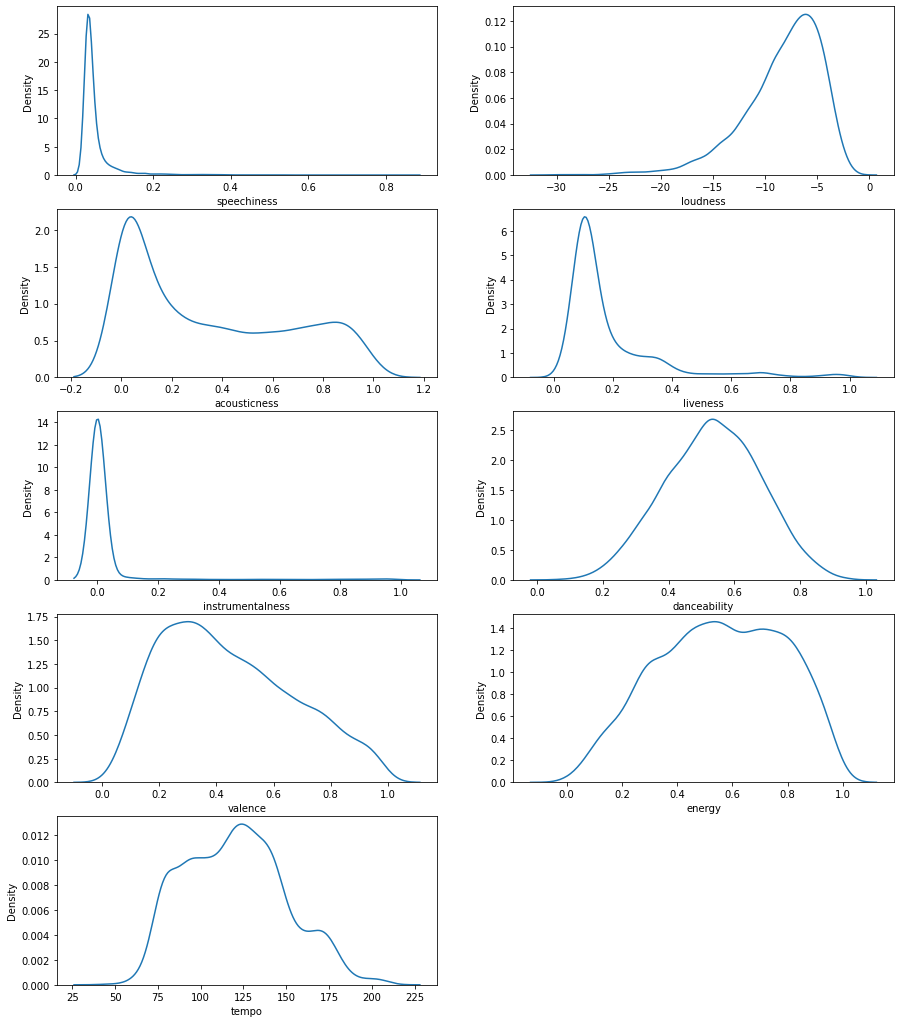

In [53]:
plt.figure(figsize=(15,18))

numRows = 5
numColumns = 2

plt.subplot(numRows, numColumns, 1); 
sns.kdeplot(data=df, x="speechiness")

plt.subplot(numRows, numColumns,2)
sns.kdeplot(data=df, x="loudness")

plt.subplot(numRows, numColumns, 3);
sns.kdeplot(data=df, x="acousticness")

plt.subplot(numRows, numColumns, 4);
sns.kdeplot(data=df, x="liveness")

plt.subplot(numRows, numColumns,5);
sns.kdeplot(data=df, x="instrumentalness")

plt.subplot(numRows, numColumns, 6); 
sns.kdeplot(df['danceability'])

plt.subplot(numRows, numColumns, 7); 
sns.kdeplot(df['valence'])

plt.subplot(numRows, numColumns, 8); 
sns.kdeplot(df['energy'])

plt.subplot(numRows, numColumns, 9); 
sns.kdeplot(df['tempo'])



## Speechiness

One way to do it would be to rely merely on the data understanding too.
df = df.loc[df.speechiness <= 0.33]

<font color="blue"> 
    
It was found there was not a high representation for tracks with speech-like tracks, only 18 register fit under this category. Therefore an outlier treatment was applied for this case. The skewness went from highly to moderate.
</font>

In [29]:
df.speechiness.describe()

count    3493.000000
mean        0.049138
std         0.045063
min         0.022400
25%         0.030100
50%         0.035600
75%         0.047600
max         0.861000
Name: speechiness, dtype: float64

In [30]:
len(df.loc[df.speechiness > 0.33][['speechiness']])

18

### Checking Variance

In [31]:
print(df.speechiness.var())

0.0020306414441581574


In [32]:
df.speechiness.value_counts()

0.0278    31
0.0299    27
0.0324    26
0.0279    26
0.0308    26
          ..
0.1230     1
0.0987     1
0.0558     1
0.0575     1
0.0580     1
Name: speechiness, Length: 693, dtype: int64

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


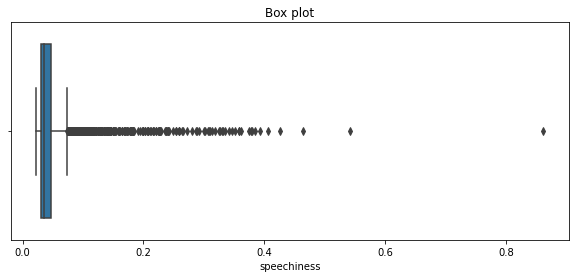

In [33]:

plt.figure(figsize=(10,4))
plt.title('Box plot')
sns.boxplot(df.speechiness)
plt.show()

<Figure size 720x288 with 0 Axes>

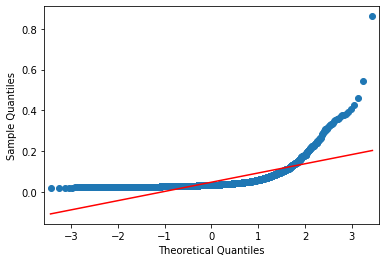

In [34]:
from statsmodels.graphics.gofplots import qqplot
plt.figure(figsize=(10,4))
qqplot(df.speechiness, line='s')
plt.show()

In [35]:
totalRows = len(df.speechiness)
range1 = len(df.speechiness[df.speechiness <= 0.33])
range2 = len(df.speechiness.loc[(df.speechiness > 0.33) & (df.speechiness >= 0.66)])
range3 = len(df.speechiness.loc[(df.speechiness > 0.66)])


print('less than 0.33          | ', range1/totalRows , str(round(range1, 2)) )
print('btw than 0.33 and 0.66  | ', range2/totalRows , str(round(range2, 2)))
print('over than 0.5           | ', range3/totalRows, str(round(range3, 2)))

less than 0.33          |  0.9948468365302032 3475
btw than 0.33 and 0.66  |  0.000286286859433152 1
over than 0.5           |  0.000286286859433152 1


<font color="blue"> 
As it can be seen data is not falling into the red reference line what means that data is not normally distributed
</font>

In [36]:
deleteOutliersByField(df, 'speechiness')
printNewShapeDF(df)

amount of rows to delete greater than 75 293
amount of rows to delete lesser than 25 0
::: New Shape Dataframe (3200, 677)


/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


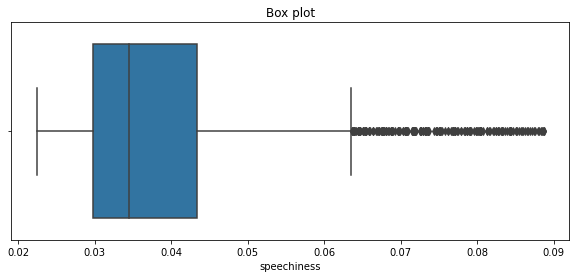

In [37]:
plt.figure(figsize=(10,4))
plt.title('Box plot')
sns.boxplot(df.speechiness)
plt.show()

In [38]:
totalRows = len(df.speechiness)
range1 = len(df.speechiness[df.speechiness <= 0.33])
range2 = len(df.speechiness.loc[(df.speechiness > 0.33) & (df.speechiness >= 0.66)])
range3 = len(df.speechiness.loc[(df.speechiness > 0.66)])


print('less than 0.33          | ', range1/totalRows , str(round(range1, 2)) )
print('btw than 0.33 and 0.66  | ', range2/totalRows , str(round(range2, 2)))
print('over than 0.5           | ', range3/totalRows, str(round(range3, 2)))

less than 0.33          |  1.0 3200
btw than 0.33 and 0.66  |  0.0 0
over than 0.5           |  0.0 0


<Figure size 720x288 with 0 Axes>

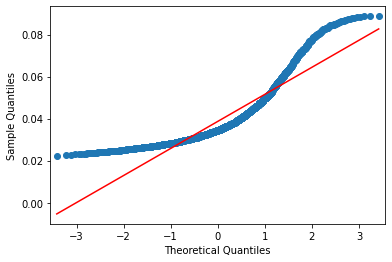

In [39]:
from statsmodels.graphics.gofplots import qqplot
plt.figure(figsize=(10,4))
qqplot(df.speechiness, line='s')
plt.show()

***After removing outliers the skewness of speechiness improved significantly, now it is moderate***

In [40]:
df[['speechiness']].skew(axis = 0, skipna = True)

speechiness    1.630504
dtype: float64

In [41]:
print(df.speechiness.var())

0.00016558631584479523


## Instrumentalness highly skewed

https://towardsdatascience.com/top-3-methods-for-handling-skewed-data-1334e0debf45
    https://towardsdatascience.com/avoid-mistakes-in-machine-learning-models-with-skewed-count-data-e3512b94d745

<font color="blue"> 
Instrumentalness is a valuable feature because it determines how much vocal a song includes, however it contains continous features and it is highly skewed, so we're going to check whether binning here makes more sense.
</font>

In [42]:
df.instrumentalness.describe()

count    3200.000000
mean        0.029387
std         0.133261
min         0.000000
25%         0.000000
50%         0.000004
75%         0.000345
max         0.985000
Name: instrumentalness, dtype: float64

In [43]:
totalRows = len(df.instrumentalness)
range1 = len(df.instrumentalness[df.instrumentalness < 0.5])
range2 = len(df.instrumentalness[df.instrumentalness > 0.5])
print('less than 0.5', range1/totalRows , range1)
print('over than 0.5', range2/totalRows, range2)

less than 0.5 0.974375 3118
over than 0.5 0.025625 82


<Figure size 720x288 with 0 Axes>

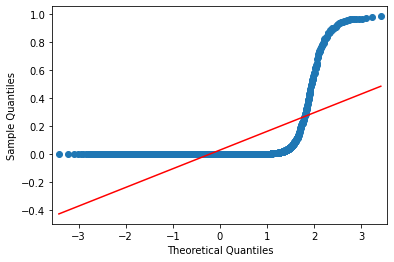

In [44]:
from statsmodels.graphics.gofplots import qqplot
plt.figure(figsize=(10,4))
qqplot(df.instrumentalness, line='s')
plt.show()

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


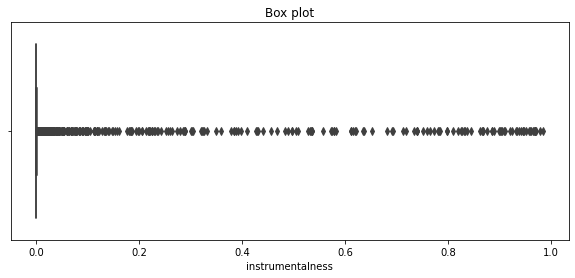

In [45]:
plt.figure(figsize=(10,4))
plt.title('Box plot')
sns.boxplot(df.instrumentalness)
plt.show()

<font color="blue"> 
    Since Values below 0.5 represent almost the 98% or observations a binning approach has been decided, since logarithm approach was not appropiate in this case
</font>

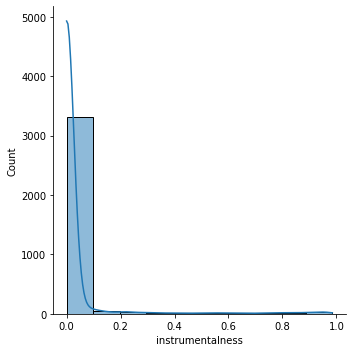

In [54]:
 sns.displot(data=df, x="instrumentalness", kde=True, bins=10)

**The following bins were created**

In [55]:
df.instrumentalness.value_counts()

0.000000    1493
0.001040       6
0.000001       5
0.000011       5
0.000002       5
            ... 
0.000824       1
0.682000       1
0.000064       1
0.001170       1
0.005870       1
Name: instrumentalness, Length: 1484, dtype: int64

<font color="blue"> 
Binning using quantiles a total of 3 categories were created
</font>

In [56]:

df['instrumentalness_cat'] = df.apply(getInstrumentalnessCat, axis=1)

In [57]:
df['instrumentalness_cat'].value_counts()

0    1493
1    1003
2     997
Name: instrumentalness_cat, dtype: int64

***Dropping the previous instrumentalness column**

In [58]:
df = df.drop(['instrumentalness'], axis=1)

## Liveness

In [59]:
df.liveness.describe()

count    3493.000000
mean        0.186559
std         0.165943
min         0.019700
25%         0.097200
50%         0.119000
75%         0.206000
max         0.993000
Name: liveness, dtype: float64

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


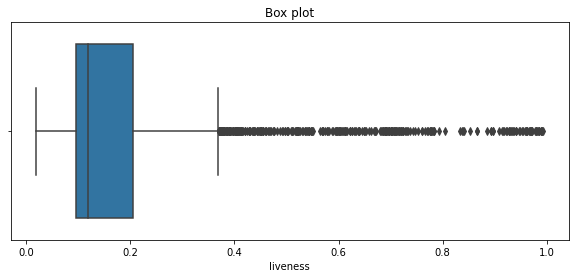

In [60]:
plt.figure(figsize=(10,4))
plt.title('Box plot')
sns.boxplot(df.liveness)
plt.show()

## Hot Encoding Categorical features

In [61]:
df.columns

Index(['id_spotify_track', 'id_track', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'liveness',
       ...
       '1278', '1281', '1286', '1287', '1288', '1290', '1292', '1294', '1295',
       'instrumentalness_cat'],
      dtype='object', length=684)

In [65]:
# changing types 
categoricalFeatures = ['key', 'time_signature', 'mode', 'mood', 'instrumentalness_cat']
df = df.astype({"key": int,"time_signature": int, "mode": int, "mood": int })

ValueError: Cannot convert non-finite values (NA or inf) to integer

ValueError: Could not interpret value `instrumentalness_cat` for parameter `x`

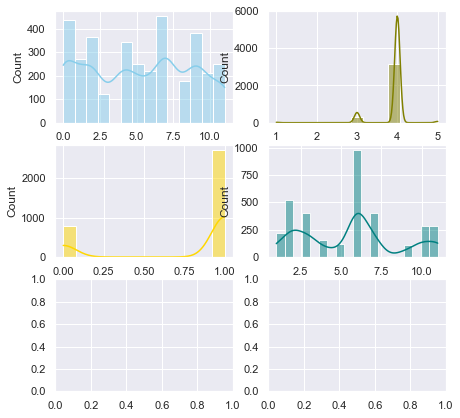

In [66]:
sns.set(style="darkgrid")

fig, axs = plt.subplots(3, 2, figsize=(7, 7))

sns.histplot(data=df, x="key", kde=True, color="skyblue", ax=axs[0, 0])
sns.histplot(data=df, x="time_signature", kde=True, color="olive", ax=axs[0, 1])
sns.histplot(data=df, x="mode", kde=True, color="gold", ax=axs[1, 0])
sns.histplot(data=df, x="mood", kde=True, color="teal", ax=axs[1, 1])
sns.histplot(data=df, x="instrumentalness_cat", kde=True, color="teal", ax=axs[2, 0])

#### Joining time signatures into two categories

In [645]:
df.time_signature.value_counts()

4    2854
3     292
5      34
1       9
Name: time_signature, dtype: int64

In [646]:
 df.time_signature = df.apply(lambda x : 1 if x.time_signature == 4 else 0, axis=1)

In [647]:
df.time_signature.value_counts()

1    2854
0     335
Name: time_signature, dtype: int64

### Hot encoding

In [648]:
categDF = df[categoricalFeatures]

In [649]:
categDF

,key,time_signature,mode,mood,instrumentalness_cat
id,,,,,
23,7,1,1,7,2
105,7,1,1,10,2
118,2,1,1,7,1
120,11,1,0,7,2
292,6,1,1,3,0
...,...,...,...,...,...
3781055,1,1,1,7,0
3860363,10,0,1,3,0
3898172,6,1,1,6,2


In [650]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(categDF)
OneHotEncoder(handle_unknown='ignore')

OneHotEncoder(handle_unknown='ignore')

In [651]:
enc.categories_


[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 array([0, 1]),
 array([0, 1]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 array([0, 1, 2])]

In [652]:
hotEncodedCatFeatures = pd.DataFrame(enc.transform(categDF).toarray())

In [653]:
hotEncodedCatFeatures.head(1)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [655]:
c, encodedFeaturesNames  = getRenameObject(enc, ['key', 'time_signature', 'mode', 'mood', 'instrumentalness_cat'])
hotEncodedCatFeatures = hotEncodedCatFeatures.rename(columns=c)

In [656]:
hotEncodedCatFeatures.head(1)

,key_0,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,...,mood_5,mood_6,mood_7,mood_8,mood_9,mood_10,mood_11,instrumentalness_cat_0,instrumentalness_cat_1,instrumentalness_cat_2
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Checking Variance


<font color="blue"> 
All columns passed the variance threshold
</font>

In [67]:
continousFeatures = df[['danceability', 'energy', 'speechiness', 'acousticness', 'liveness', 'valence', 'tempo']]

In [68]:
from sklearn.feature_selection import VarianceThreshold

# Create a VarianceThreshold feature selector
sel = VarianceThreshold(threshold=0.001)

# Fit the selector to normalized head_df
sel.fit(continousFeatures / continousFeatures.mean())

# Create a boolean mask
mask = sel.get_support()

# Apply the mask to create a reduced dataframe
reduced_df = continousFeatures.loc[:, mask]

#### Dropping ID column


<font color="blue"> 
Loudness and energy were the features with the highest correlation, which is not a surprise since loudness is a way to represent the intensity of a sound, or in other words the amount of energy in sound waves.
</font>

In [69]:
df = df.drop(['key', 'time_signature', 'mode', 'mood', 'instrumentalness_cat', 'loudness'], axis=1)

KeyError: "['instrumentalness_cat'] not found in axis"

In [70]:
df = pd.concat([df.reset_index(), hotEncodedCatFeatures], axis=1)

NameError: name 'hotEncodedCatFeatures' is not defined

In [71]:
df.head(1)

,id_spotify_track,id_track,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,...,1276,1278,1281,1286,1287,1288,1290,1292,1294,1295
id,,,,,,,,,,,,,,,,,,,,,
23,2ap1hCe7wyOWkMJsnIn0V1,1,0.494,0.756,7,-8.504,1,0.0432,0.0014,0.0052,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [662]:
os.makedirs('./data', exist_ok=True)  
df.to_csv('./data/05-RawData.csv')

In [663]:
y = pd.Series(encodedFeaturesNames)
y.to_csv('./data/05-encodedFeatureNames.csv')


In [664]:
encodedFeaturesNames

array(['key_0', 'key_1', 'key_2', 'key_3', 'key_4', 'key_5', 'key_6',
       'key_7', 'key_8', 'key_9', 'key_10', 'key_11', 'time_signature_0',
       'time_signature_1', 'mode_0', 'mode_1', 'mood_1', 'mood_2',
       'mood_3', 'mood_4', 'mood_5', 'mood_6', 'mood_7', 'mood_8',
       'mood_9', 'mood_10', 'mood_11', 'instrumentalness_cat_0',
       'instrumentalness_cat_1', 'instrumentalness_cat_2'], dtype=object)